
EE4414 Team Practice Effnetb0 AdvReq(1): Classifying "Others" class
==============================================

In this team practice, you will design Convolutional Neural Network(s) to classify food images.




In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy


plt.ion()   # interactive mode

## 1. Loading data

Define the dataset, dataloader, and the data augmentation pipeline.

The code below loads 5 classes from all 12 classes in the dataset. You need to modify it to load only the classes that you need.

***Note: For correctly assessing your code, do not change the file structure of the dataset. Use Pytorch data loading utility (`torch.utils.data`) for customizing your dataset.***

In [3]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [4]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(brightness=10, contrast=5),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}

data_dir = os.path.join('data', 'sg_food')
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset
selected_classes = [3,5,7,8,9] # Change the class according to group matrix number
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [3, 5, 7, 8, 9]
    name: ['Hokkien Prawn Mee', 'Laksa', 'Oyster Omelette', 'Roast Meat Rice', 'Roti Prata']


In [5]:
dataset_sizes

{'train': 500, 'val': 150}

## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 



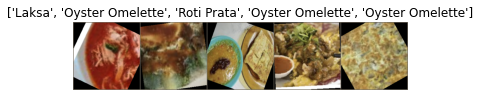

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])

imshow(out, title=[class_names[x] for x in classes[:5]])

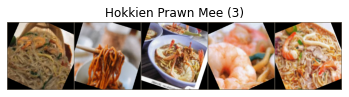

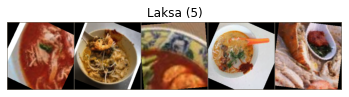

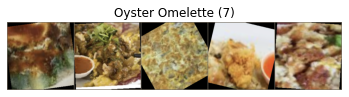

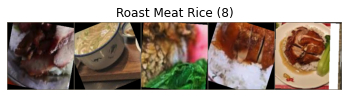

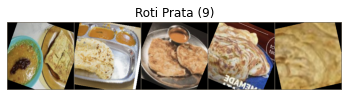

In [7]:
out3_Hokkien_Prawn_Mee = np.where(classes.numpy() == 0)
out5_Kaya_Toast_and_Egg = np.where(classes.numpy() == 1)
out7_Oyster_Omelette = np.where(classes.numpy() == 2)
out8_Roast_Meat_Rice = np.where(classes.numpy() == 3)
out9_Roti_Prata = np.where(classes.numpy() == 4)

out3_Hokkien_Prawn_Mee
out5_Kaya_Toast_and_Egg
out7_Oyster_Omelette
out8_Roast_Meat_Rice
out9_Roti_Prata

out3 = torchvision.utils.make_grid(inputs[out3_Hokkien_Prawn_Mee[0][:5]])
out5 = torchvision.utils.make_grid(inputs[out5_Kaya_Toast_and_Egg[0][:5]])
out7 = torchvision.utils.make_grid(inputs[out7_Oyster_Omelette[0][:5]])
out8 = torchvision.utils.make_grid(inputs[out8_Roast_Meat_Rice[0][:5]])
out9 = torchvision.utils.make_grid(inputs[out9_Roti_Prata[0][:5]])

imshow(out3, title = class_names[0] + ' (3)')
imshow(out5, title = class_names[1] + ' (5)')
imshow(out7, title = class_names[2] + ' (7)')
imshow(out8, title = class_names[3] + ' (8)')
imshow(out9, title = class_names[4] + ' (9)')

## 3. Defining function to train the model

Use a pre-trained CNN model with transfer learning techniques to classify the 5 food categories.

(Note: The provided code is only for reference. You can modify the code whichever way you want.)


In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    # TODO
    since = time.time()
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        t1 = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step()
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            if phase == 'val':
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        t2=time.time()
        print('Time:'+str(t2-t1))
        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (train_loss_list, val_loss_list, train_acc_list, val_acc_list)

## 4. Training and validating the model

Train your model for minimum 3 epochs.

### 4.1 Loading pretrained model and defining new classfier layer


In [9]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

# (code)
# model = models.resnet18(pretrained=True)
# model = models.resnet34(pretrained=True)
# model = models.resnet50(pretrained=True)
# model = models.vgg16(pretrained=True)
# model = models.alexnet(pretrained=True)

model = models.efficientnet_b0(pretrained=True)


# 2. Modify the pretrain model for your task.

# (code)
for param in model.parameters():  # freeze layers
    param.requires_grad = False

# num_ftrs = model.fc.in_features # resnet
# model.fc = nn.Linear(num_ftrs, 5) # resnet

num_ftrs = model.classifier[-1].in_features # vgg16/alexnet/effnet
model.classifier[-1] = nn.Linear(num_ftrs, 5) # vgg16/alexnet/effnet


model = model.to(device)


# # 3. Choose your loss function, optimizer, etc.

# # (code)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


### 4.2 Printing and visualizing the modified model

In [10]:
# TODO
print(model)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [11]:
# TODO
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

### 4.3 Training using train data and evaluating using validation data

Train your model for minimum 3 epochs.

In [12]:
# TODO 
model, history = train_model(model, criterion, optimizer,
                             scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 1.2721 Acc: 0.4700
val Loss: 0.6948 Acc: 0.7800
Time:31.003563404083252

Epoch 2/10
----------
train Loss: 0.8358 Acc: 0.7020
val Loss: 0.6407 Acc: 0.7733
Time:31.333173036575317

Epoch 3/10
----------
train Loss: 0.7462 Acc: 0.7500
val Loss: 0.5228 Acc: 0.8200
Time:31.637359142303467

Epoch 4/10
----------
train Loss: 0.6505 Acc: 0.7540
val Loss: 0.4829 Acc: 0.8533
Time:31.73809003829956

Epoch 5/10
----------
train Loss: 0.6868 Acc: 0.7560
val Loss: 0.5112 Acc: 0.8400
Time:33.85149025917053

Epoch 6/10
----------
train Loss: 0.6527 Acc: 0.7780
val Loss: 0.5128 Acc: 0.8467
Time:32.7254478931427

Epoch 7/10
----------
train Loss: 0.5950 Acc: 0.7900
val Loss: 0.5105 Acc: 0.8333
Time:31.290196895599365

Epoch 8/10
----------
train Loss: 0.6265 Acc: 0.7680
val Loss: 0.4819 Acc: 0.8533
Time:31.631375551223755

Epoch 9/10
----------
train Loss: 0.5640 Acc: 0.8000
val Loss: 0.4550 Acc: 0.8600
Time:31.695234775543213

Epoch 10/10
----------
train Loss: 0.5956

## PLOT LOSS

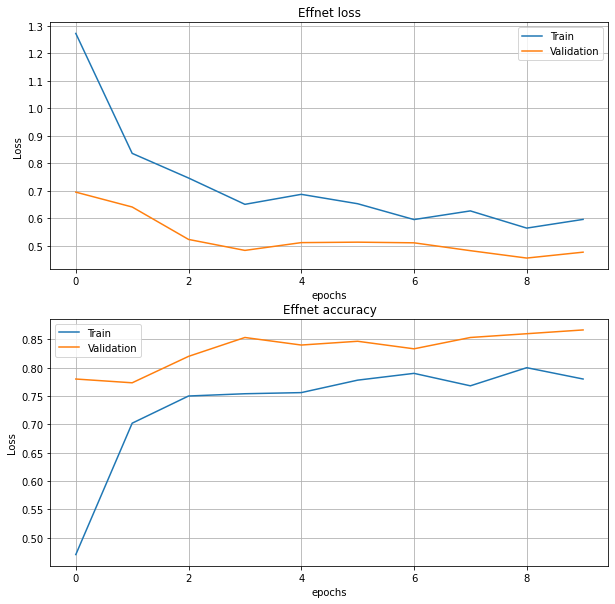

In [13]:
train_loss_list = history[0]
val_loss_list = history[1]
train_acc_list = history[2]
val_acc_list = history[3]

iterations = np.arange(10)

fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(iterations, train_loss_list)
ax[0].plot(iterations, val_loss_list)
ax[0].set(xlabel='epochs', ylabel='Loss', title='Effnet loss')
ax[0].grid()

ax[1].plot(iterations, train_acc_list)
ax[1].plot(iterations, val_acc_list)
ax[1].set(xlabel='epochs', ylabel='Loss', title='Effnet accuracy')
ax[1].grid()

ax[0].legend(['Train','Validation'])
ax[1].legend(['Train','Validation'])
plt.show()

## 5. Loading test data

Define the dataset and dataloader for testing.

In [14]:
test_dir = os.path.join('data', 'sg_food', 'test')

# selected_test_classes = selected_classes
selected_test_classes = [3,5,7,8,9]

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_test_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)
test_class_names = test_dataset.classes

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

In [15]:
test_class_names

['Hokkien Prawn Mee',
 'Laksa',
 'Oyster Omelette',
 'Roast Meat Rice',
 'Roti Prata']

## 6. Visualizing the predictions

Predict the label on a few testing samples and visualize the results.

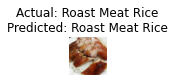

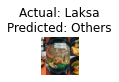

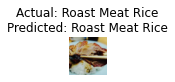

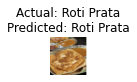

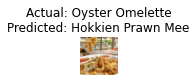

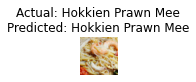

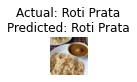

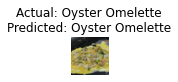

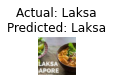

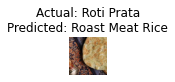

In [16]:
new_class_names = class_names.copy()
new_test_class_names = test_class_names.copy()
new_class_names.append('Others')
# new_test_class_names.append('Others')
save_softmax = []

def visualize_model_new(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # softmax thresholding for predictions that do not belong to any class
            sm = nn.Softmax(1)
            softmax_output = sm(outputs)
            save_softmax.extend(softmax_output.numpy())
            softmax_values, preds = torch.max(softmax_output, 1)

            # replace prediction values where the softmax value is less than threshold value
            preds[np.where(softmax_values.numpy() < 0.6)] = len(class_names) # add 1 more class to class_names->[0,1,2,3,4,5], last class will be 'none of the above'
        
#             _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Actual: ' + new_test_class_names[labels[j]] + '\nPredicted: {}'.format(new_class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model_new(model)

## 7. Evaluating on test set

Evaluate your model on the whole test set and compute the accuracy.

In [17]:
model.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

y_pred = []
y_true = []
save_softmax = []

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        y_true.extend(labels.numpy())
        
        # Predict on the test set
        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        
        y_pred.extend(preds.numpy())
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))

Evaluation
----------
Testing Acc: 0.7958


Text(0.5, 42.0, 'Predicted Class')

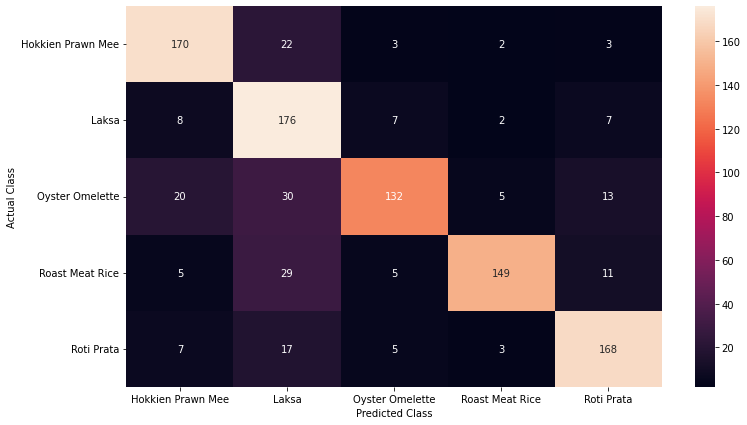

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

class_names
new_class_names
new_test_class_names

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names],
                     columns = [i for i in class_names])
df_cm_percent = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, fmt='', annot=True)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

## 8. Evaluating on test set with extra class

In [19]:
## Load Test data
test_dir = os.path.join('data', 'sg_food', 'test')

# selected_test_classes = selected_classes
selected_test_classes = [3,5,7,8,9,10] # Last class is the extra class

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_test_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)
test_class_names = test_dataset.classes

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

new_class_names = class_names.copy()
new_test_class_names = test_class_names.copy()
new_class_names.append('Others')
# new_test_class_names.append('Others')
new_test_class_names, new_class_names

(['Hokkien Prawn Mee',
  'Laksa',
  'Oyster Omelette',
  'Roast Meat Rice',
  'Roti Prata',
  'Satay'],
 ['Hokkien Prawn Mee',
  'Laksa',
  'Oyster Omelette',
  'Roast Meat Rice',
  'Roti Prata',
  'Others'])

In [20]:
model.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

y_pred = []
y_true = []
save_softmax = []

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        y_true.extend(labels.numpy())
        
        # Predict on the test set
        outputs = model(inputs)
        
        # softmax thresholding for predictions that do not belong to any class
        sm = nn.Softmax(1)
        softmax_output = sm(outputs)
        save_softmax.extend(softmax_output.numpy())
        softmax_values, preds = torch.max(softmax_output, 1)
        
        # replace prediction values where the softmax value is less than threshold value
        preds[np.where(softmax_values.numpy() < 0.5)] = len(class_names) # add 1 more class to class_names->[0,1,2,3,4,5], last class will be 'Others'
        
        y_pred.extend(preds.numpy())
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.6931


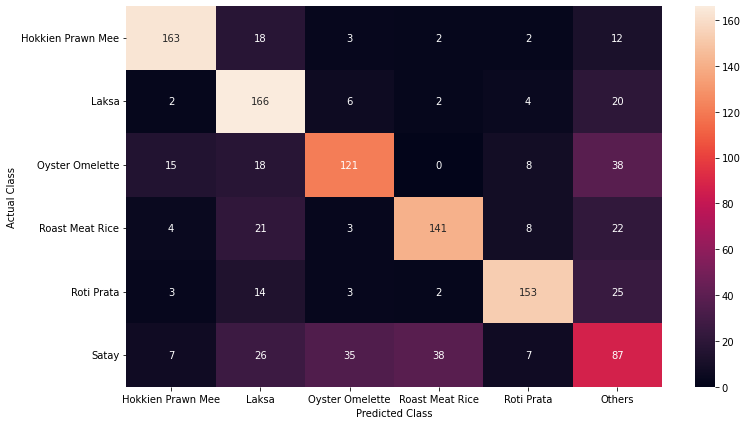

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

class_names
new_class_names
new_test_class_names

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in new_test_class_names],
                     columns = [i for i in new_class_names])
df_cm_percent = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in new_test_class_names],
                     columns = [i for i in new_class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, fmt='', annot=True)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.savefig('output.png')

In [59]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, y_pred, average='macro')

(0.7013798871715714, 0.6930904522613065, 0.6938133495581607, None)

In [60]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, y_pred)

(array([0.84020619, 0.63117871, 0.70760234, 0.76216216, 0.84065934,
        0.42647059]),
 array([0.815     , 0.83      , 0.605     , 0.70854271, 0.765     ,
        0.435     ]),
 array([0.82741117, 0.71706263, 0.65229111, 0.734375  , 0.80104712,
        0.43069307]),
 array([200, 200, 200, 199, 200, 200], dtype=int64))